# How to get started with the Wikimedia data

The [Wikipedia Structured Contents](https://www.kaggle.com/datasets/wikimedia-foundation/wikipedia-structured-contents) dataset on Kaggle contains all articles of the English and French language editions of Wikipedia, pre-parsed and outputted as structured JSON files with a consistent schema. Each JSON line holds the content of one full Wikipedia article stripped of extra markdown and non-prose sections (references, etc.).

The data is divided into multiple large `.jsonl` files. Here we will explore just one of those files: `./wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_0.jsonl`.

## Initial Setup


In [1]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from tqdm import tqdm
from datetime import datetime
import re
from wordcloud import WordCloud
import networkx as nx
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set(style="whitegrid")

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## Load Data

In [2]:
def read_jsonl(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f)):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return data

In [3]:
import kagglehub
directory = kagglehub.dataset_download("wikimedia-foundation/wikipedia-structured-contents")
file_path = directory+"/enwiki_namespace_0/enwiki_namespace_0_0.jsonl"
data = read_jsonl(file_path)
print(f"Successfully loaded {len(data)} records")

309509it [01:26, 3559.53it/s]

Successfully loaded 309509 records


## Preview Data

In [4]:
df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
for col in df.columns:
    print(f"- {col}")

Dataset shape: (309509, 17)

Columns in the dataset:
- name
- identifier
- version
- event
- url
- date_created
- date_modified
- is_part_of
- in_language
- license
- description
- sections
- abstract
- main_entity
- additional_entities
- infoboxes
- image


In [5]:
print("\nSample data:")
display(df.head())


Sample data:


,name,identifier,version,event,url,date_created,date_modified,is_part_of,in_language,license,description,sections,abstract,main_entity,additional_entities,infoboxes,image
0,Not Again SU,76716259,"{'identifier': 1220413474, 'comment': 'Added #...",{'identifier': 'fa3cae5b-8707-4f55-9fab-5baa4c...,https://en.wikipedia.org/wiki/Not_Again_SU,2024-04-23T16:50:32Z,2024-04-23T16:53:55Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,"Student organization in Syracuse, New York","[{'type': 'section', 'name': 'Abstract'}, {'ty...",NaN,NaN,NaN,NaN,NaN
1,Mike Ross (Suits),76727681,"{'identifier': 1220574416, 'comment': 'Request...",{'identifier': '22366970-ddf7-43dc-8cec-941de1...,https://en.wikipedia.org/wiki/Mike_Ross_(Suits),2024-04-24T17:12:05Z,2024-04-24T17:14:10Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,An American Legal drama series from 2011-2019,"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT List of Suits characters#Mike Ross,"{'identifier': 'Q125388612', 'url': 'https://w...","[{'identifier': 'Q125388612', 'url': 'https://...",NaN,NaN
2,Second Polish republic,76744378,"{'identifier': 1220875620, 'comment': '[[WP:AE...",{'identifier': '552624d6-5c55-45ef-a8e3-945335...,https://en.wikipedia.org/wiki/Second_Polish_re...,2024-04-26T13:30:10Z,2024-04-26T13:30:10Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,Country in Central and Eastern Europe (1918–1939),"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT #Second Polish Republic,NaN,NaN,NaN,NaN
3,Left-to-right script,76735997,"{'identifier': 1220716997, 'comment': 'create ...",{'identifier': 'aae6c4ee-bf95-4dc0-942d-5eea53...,https://en.wikipedia.org/wiki/Left-to-right_sc...,2024-04-25T13:58:39Z,2024-04-25T13:58:39Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,Convention of symbols representing language,"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT Writing system#Directionality,NaN,NaN,NaN,NaN
4,1442 in France,58128987,"{'identifier': 1145356533, 'comment': 'Alter: ...",{'identifier': 'c4526432-0a4a-42ed-8ef7-54827c...,https://en.wikipedia.org/wiki/1442_in_France,NaN,2023-03-18T18:38:51Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,List of events in the year 1442,"[{'type': 'section', 'name': 'Abstract', 'has_...",Events from the year 1442 in France,"{'identifier': 'Q56292328', 'url': 'https://ww...","[{'identifier': 'Q56292328', 'url': 'https://w...","[{'type': 'infobox', 'name': 'Year in France h...",NaN


In [7]:
display(df.head()['infoboxes'])

0                                                  NaN
1                                                  NaN
2                                                  NaN
3                                                  NaN
4    [{'type': 'infobox', 'name': 'Year in France h...
Name: infoboxes, dtype: object

## Explore Dates

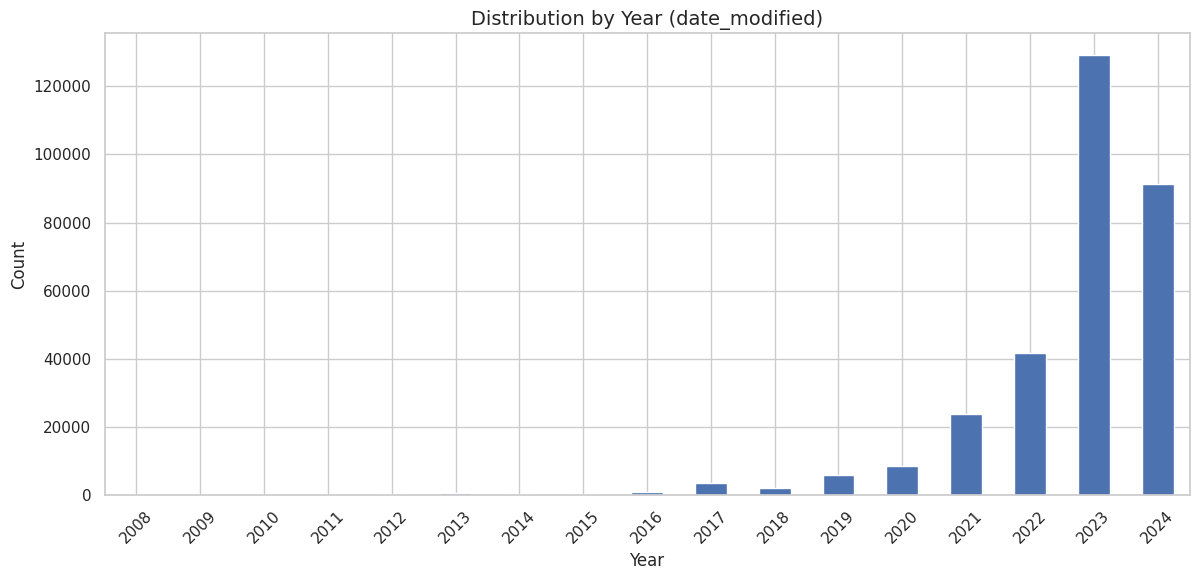

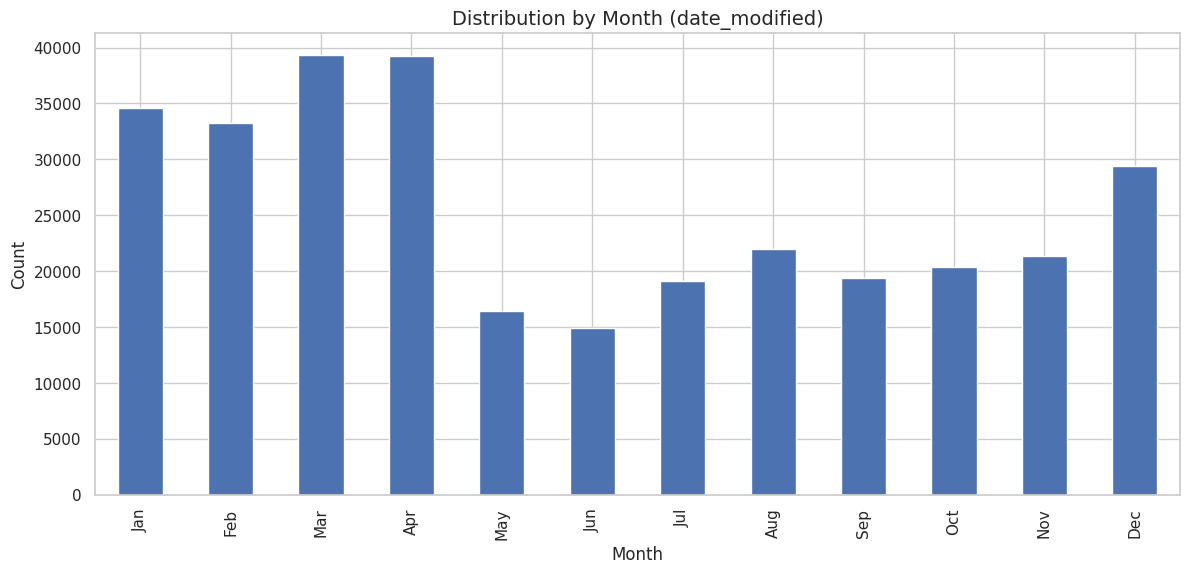

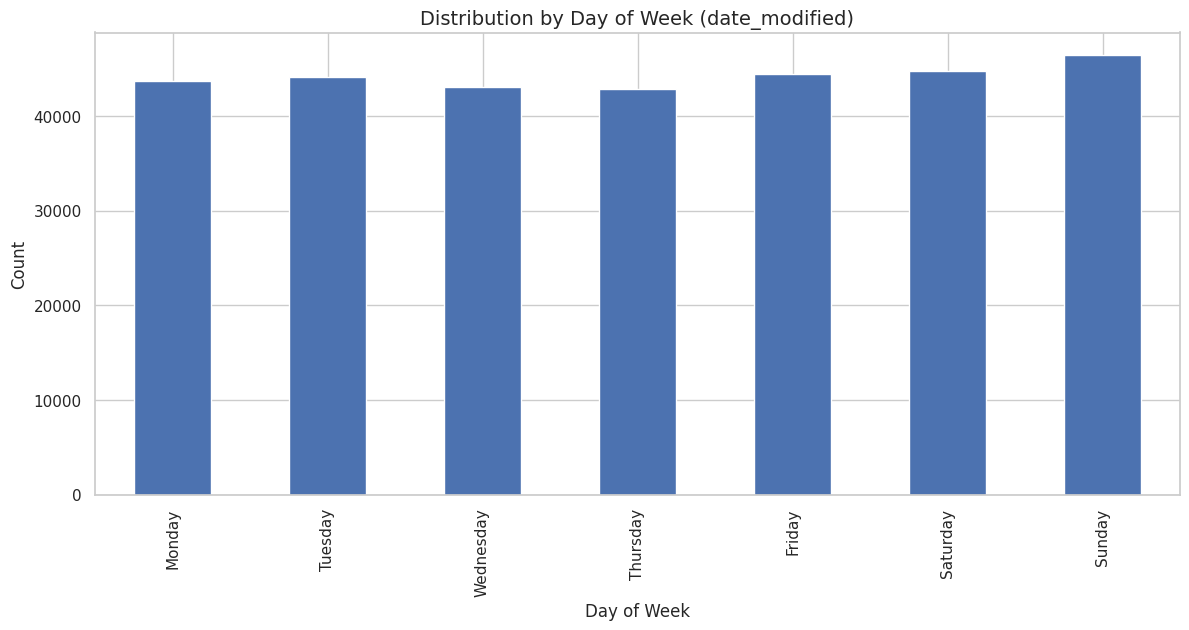

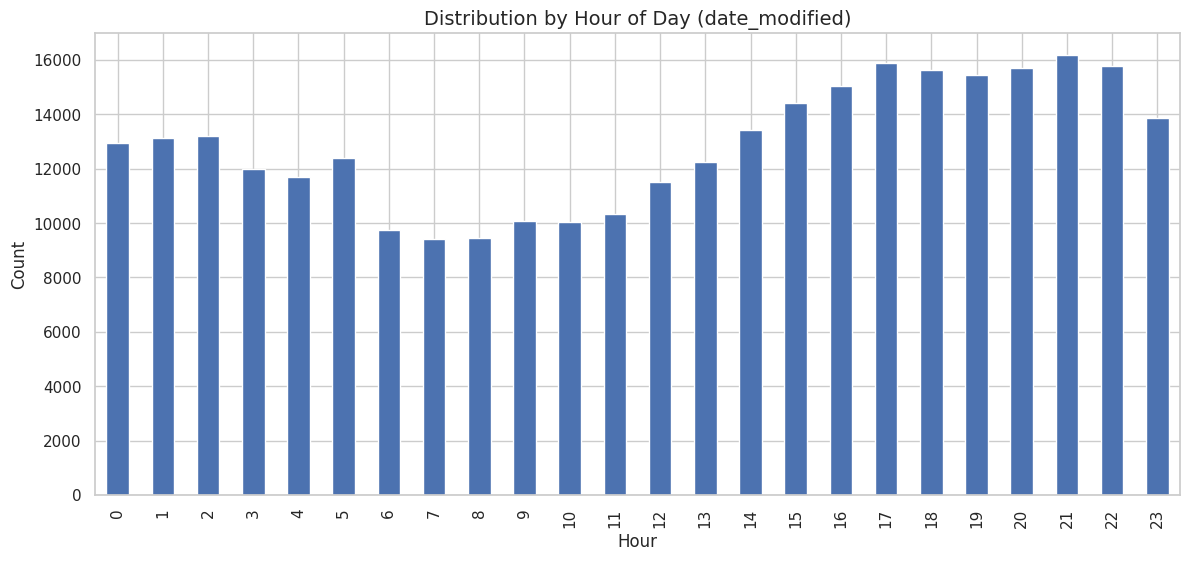

In [6]:
date_fields = ['date_modified']
for date_field in date_fields:
    if date_field in df.columns:
        try:
            df[date_field] = pd.to_datetime(df[date_field])
            df[f'{date_field}_year'] = df[date_field].dt.year
            df[f'{date_field}_month'] = df[date_field].dt.month
            df[f'{date_field}_day'] = df[date_field].dt.day
            df[f'{date_field}_hour'] = df[date_field].dt.hour
            df[f'{date_field}_weekday'] = df[date_field].dt.day_name()
        except Exception as e:
            print(f"Could not convert {date_field} to datetime: {e}")

for date_field in date_fields:
    if date_field in df.columns:
        
        # Distribution by year
        if f'{date_field}_year' in df.columns:
            plt.figure(figsize=(14, 6))
            year_counts = df[f'{date_field}_year'].value_counts().sort_index()
            year_counts.plot(kind='bar')
            plt.title(f'Distribution by Year ({date_field})', fontsize=14)
            plt.xlabel('Year', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.xticks(rotation=45)
            plt.show()
        
        # Distribution by month
        if f'{date_field}_month' in df.columns:
            plt.figure(figsize=(14, 6))
            month_counts = df[f'{date_field}_month'].value_counts().sort_index()
            month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                           7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
            month_counts.index = month_counts.index.map(lambda x: month_names.get(x, x))
            month_counts.plot(kind='bar')
            plt.title(f'Distribution by Month ({date_field})', fontsize=14)
            plt.xlabel('Month', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.show()
        
        # Distribution by day of week
        if f'{date_field}_weekday' in df.columns:
            plt.figure(figsize=(14, 6))
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            weekday_counts = df[f'{date_field}_weekday'].value_counts()
            weekday_counts = weekday_counts.reindex(day_order)
            weekday_counts.plot(kind='bar')
            plt.title(f'Distribution by Day of Week ({date_field})', fontsize=14)
            plt.xlabel('Day of Week', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.show()
        
        # Distribution by hour
        if f'{date_field}_hour' in df.columns:
            plt.figure(figsize=(14, 6))
            hour_counts = df[f'{date_field}_hour'].value_counts().sort_index()
            hour_counts.plot(kind='bar')
            plt.title(f'Distribution by Hour of Day ({date_field})', fontsize=14)
            plt.xlabel('Hour', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.show()

## Explore Names

Most common words in names:
  team: 5929
  season: 5771
  football: 5131
  men: 4661
  championships: 4278
  cup: 4113
  women: 3855
  world: 3771
  disambiguation: 3582
  list: 3296
  election: 3201
  championship: 2860
  open: 2852
  district: 2704
  league: 2634


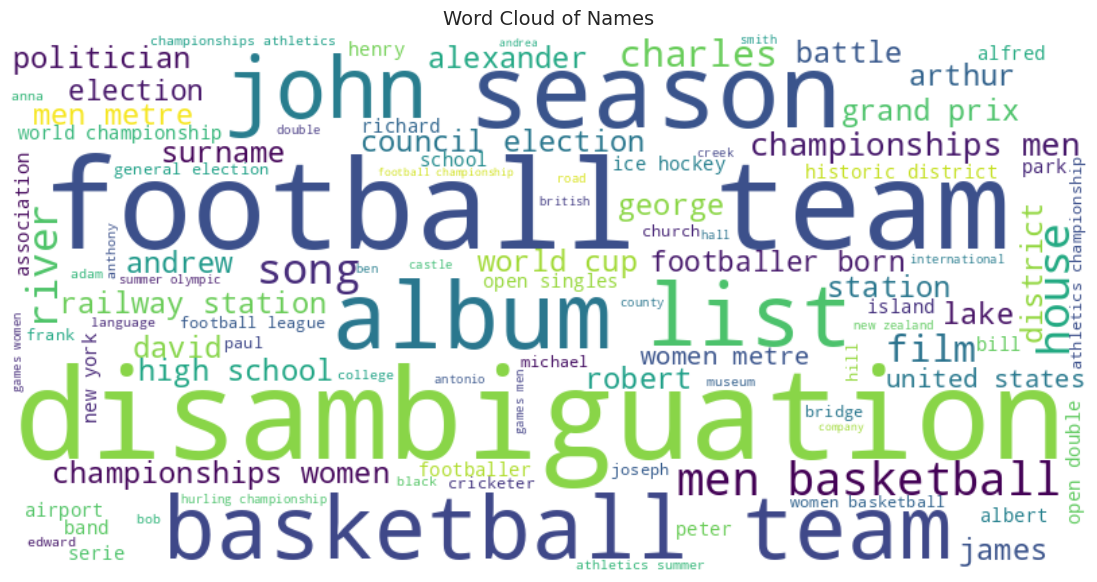

In [7]:
# Analysis for name field
if 'name' in df.columns:
    
    # Word frequency in names
    all_names = ' '.join(df['name'].dropna().astype(str))
    words = re.findall(r'\b\w+\b', all_names.lower())
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    name_word_freq = Counter(filtered_words)
    
    # Display top words
    print("Most common words in names:")
    for word, count in name_word_freq.most_common(15):
        print(f"  {word}: {count}")
    
    # Word cloud for names
    plt.figure(figsize=(14, 7))
    name_cloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(' '.join(filtered_words))
    plt.imshow(name_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Names', fontsize=14)
    plt.show()

## Explore Descriptions

Most common words in descriptions:
  term: 23534
  topics: 23388
  referred: 23387
  species: 22338
  american: 19096
  season: 14926
  football: 13288
  village: 12284
  united: 9875
  states: 9289
  politician: 8101
  footballer: 7285
  list: 6881
  tennis: 6059
  genus: 6050


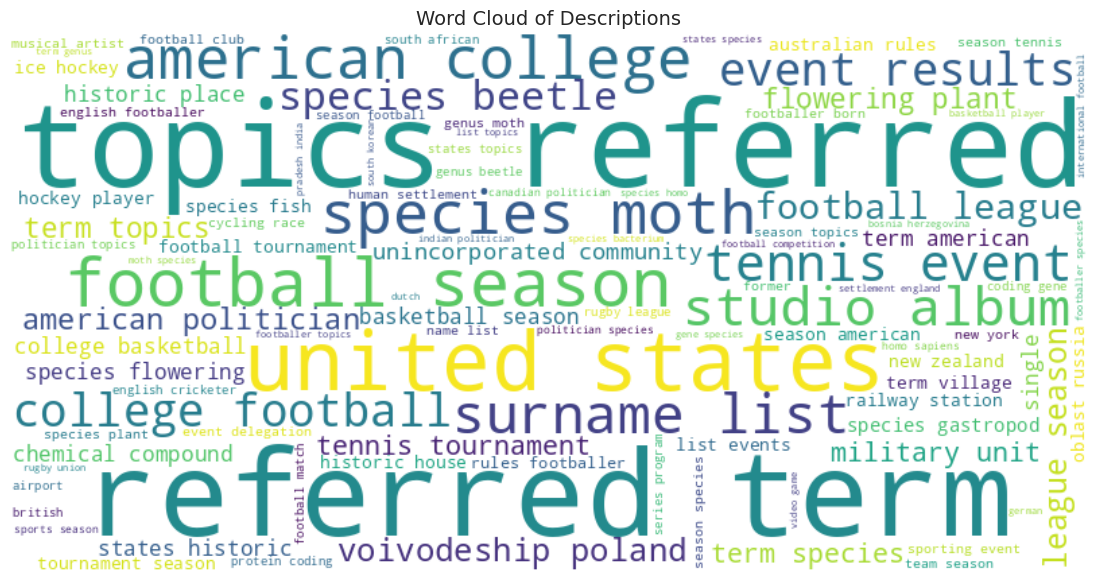

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


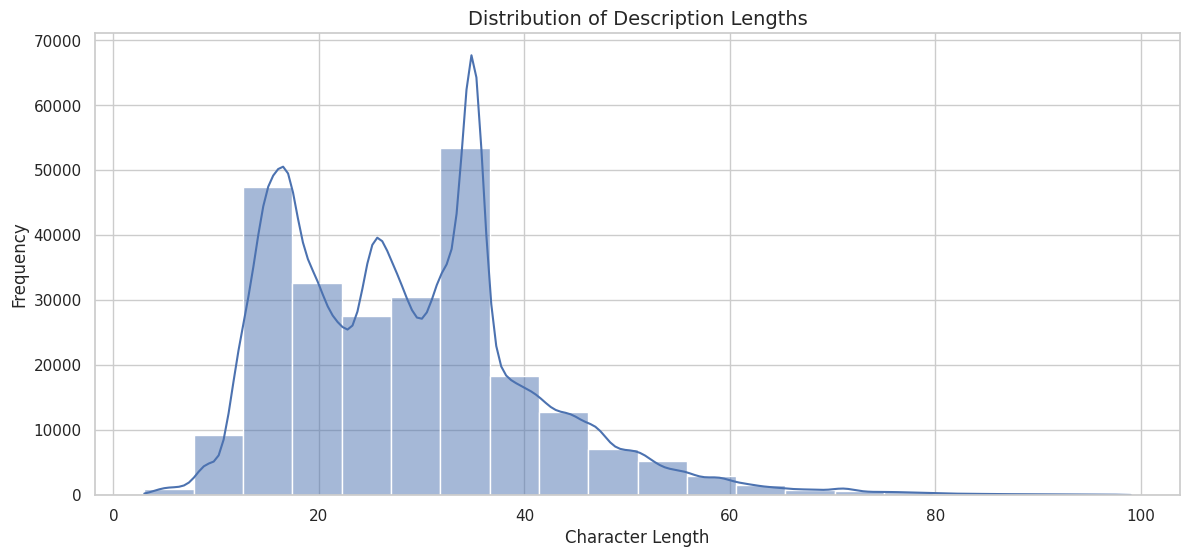

Average description length: 28.7 characters


In [8]:
# Analysis for description field
if 'description' in df.columns:
    
    # Handle descriptions as strings or lists/dicts
    descriptions = []
    for desc in df['description'].dropna():
        if isinstance(desc, str):
            descriptions.append(desc)
        elif isinstance(desc, list):
            descriptions.extend([d for d in desc if isinstance(d, str)])
    
    # Word frequency in descriptions
    all_descriptions = ' '.join(descriptions)
    words = re.findall(r'\b\w+\b', all_descriptions.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    desc_word_freq = Counter(filtered_words)
    
    # Display top words
    print("Most common words in descriptions:")
    for word, count in desc_word_freq.most_common(15):
        print(f"  {word}: {count}")
    
    # Word cloud for descriptions
    plt.figure(figsize=(14, 7))
    desc_cloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(' '.join(filtered_words))
    plt.imshow(desc_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Descriptions', fontsize=14)
    plt.show()
    
    # Description length analysis
    desc_lengths = [len(d) for d in descriptions]
    plt.figure(figsize=(14, 6))
    sns.histplot(desc_lengths, bins=20, kde=True)
    plt.title('Distribution of Description Lengths', fontsize=14)
    plt.xlabel('Character Length', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()
    
    print(f"Average description length: {np.mean(desc_lengths):.1f} characters")

## Explore Abstracts

Average abstract length: 396.8 characters


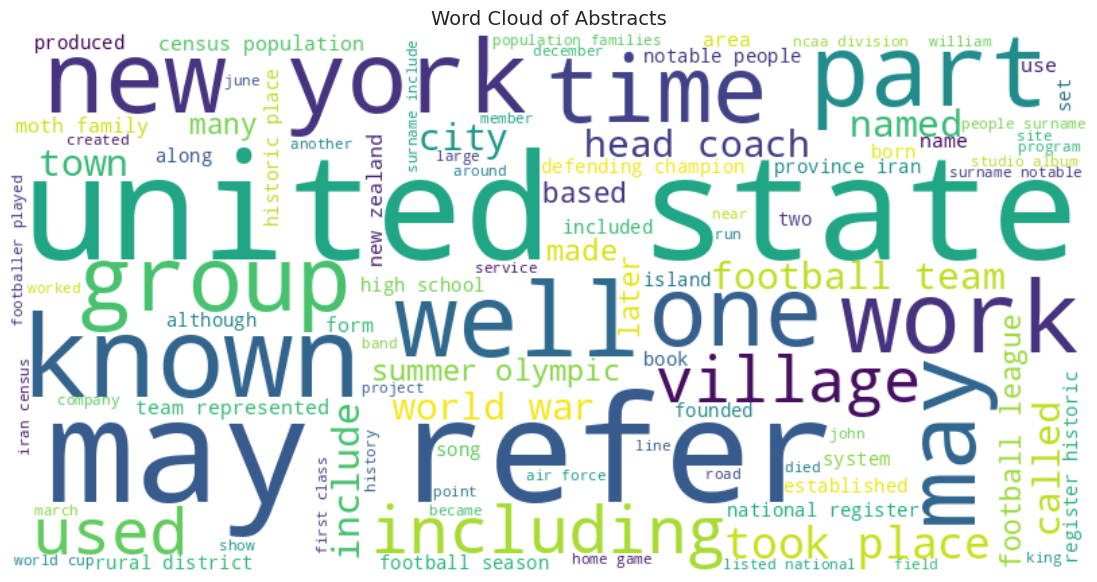

In [9]:
if 'abstract' in df.columns:
    
    # Handle abstracts as strings or lists/dicts
    abstracts = []
    for abstract in df['abstract'].dropna():
        if isinstance(abstract, str):
            abstracts.append(abstract)
        elif isinstance(abstract, list):
            abstracts.extend([a for a in abstract if isinstance(a, str)])

    abstract_lengths = [len(a) for a in abstracts]
    print(f"Average abstract length: {np.mean(abstract_lengths):.1f} characters")
    
    # Word cloud for abstracts
    if abstracts:
        all_abstracts = ' '.join(abstracts)
        words = re.findall(r'\b\w+\b', all_abstracts.lower())
        filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
        
        plt.figure(figsize=(14, 7))
        abstract_cloud = WordCloud(width=800, height=400,
                                 background_color='white',
                                 max_words=100).generate(' '.join(filtered_words))
        plt.imshow(abstract_cloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Abstracts', fontsize=14)
        plt.show()

## Explore Sections

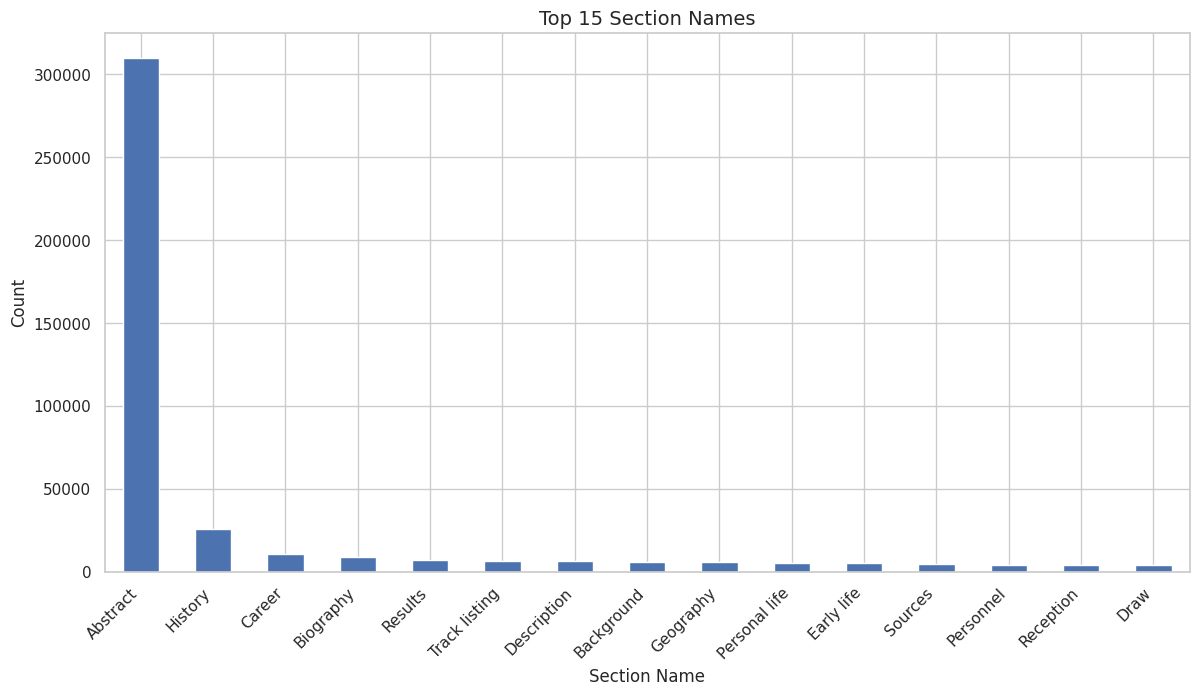

Abstract         309445
History           25613
Career            10708
Biography          9039
Results            6937
Track listing      6536
Description        6378
Background         5665
Geography          5577
Personal life      5317
Early life         4986
Sources            4653
Personnel          3965
Reception          3784
Draw               3779
dtype: int64

In [10]:
if 'sections' in df.columns:
    
    # Count number of sections per record
    section_counts = []
    section_names = []
    
    for sections in df['sections'].dropna():
        if isinstance(sections, list):
            section_counts.append(len(sections))
            # Extract section names (assuming sections is a list of dicts with 'name' key)
            for section in sections:
                if isinstance(section, dict) and 'name' in section:
                    section_names.append(section['name'])
    
    # Top section names
    if section_names:
        section_name_counts = Counter(section_names)
        
        plt.figure(figsize=(14, 7))
        pd.Series(section_name_counts).nlargest(15).plot(kind='bar')
        plt.title('Top 15 Section Names', fontsize=14)
        plt.xlabel('Section Name', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.show()
        
        display(pd.Series(section_name_counts).nlargest(15))


## Explore Images

Records with images: 90607 (29.3%)
Records without images: 218902 (70.7%)


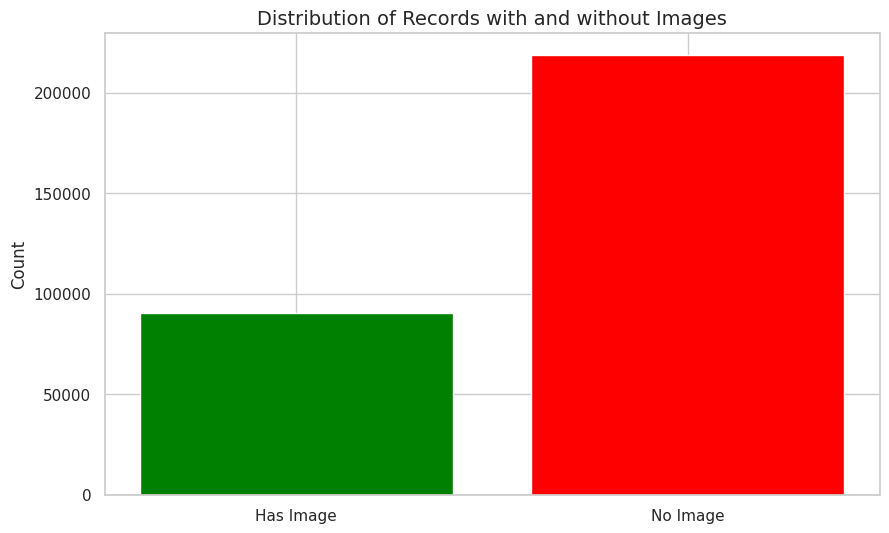

In [11]:
if 'image' in df.columns:
    
    # Count number of records with images
    image_present = df['image'].notna()
    image_count = image_present.sum()
    no_image_count = (~image_present).sum()
    
    print(f"Records with images: {image_count} ({image_count/len(df)*100:.1f}%)")
    print(f"Records without images: {no_image_count} ({no_image_count/len(df)*100:.1f}%)")
    
    # Visualize image presence distribution
    plt.figure(figsize=(10, 6))
    plt.bar(['Has Image', 'No Image'], [image_count, no_image_count], color=['green', 'red'])
    plt.title('Distribution of Records with and without Images', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.show()
